# Grundwasser Extremereignis Vorhersage mit Random Forest

Ziel sind erste Versuche ein einfaches RF Modell zur Vorhersage von Extremereignissen bei Grundwasserstandsänderungen. Hierfür werden als Datan Niederschlag, Temperatur und bisherige Grundwasserstandsänderungen genutzt.

In [1]:
from tools.InstanceAssembler import point_data_assembler
from tools.FeatureHandlers import RegnieHandler, DWDAirTempHandler, UTMEastingHandler, UTMNorthingHandler, XtremeBoundHandler, GwLvlChangeHandler
from tools.TargetHandlers import XtremeClassificationHandler
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
from datetime import date, timedelta
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import shap

## Instanzen zusammestellen
Betrachtet werden 329 als nicht anthropogen beeinflusste Stationen in Hesser für den Zielwert-Zeitraum von Feb. 2009 bis Dez. 2017 gewonnen.

Zielwert ist eine Klassifikation der Grundwasserstandsänderung innerhalb 4 Wochen in extrem fallend (5. Perzentil), exstrem steigend (95. Perzentil) und normale Änderung.

Der Eingabezeitraum beträgt 52 Wochen mit einer zeitlichen Auflösung von 1 Woche.

**Features:**
- Niederschlags- und Temperaturdaten als Rasterdurchschnitt, Einflussgröße 11x11 km
- Grundwasserstandsänderung zu jeweil 4 Wochen davor
- Geokoordinaten der Messstation
- Median, 5. und 9. Perzentil der Grundwasserstandsänderungen im Trainingszeitraum

In [2]:
stations = pd.read_csv(r'G:/GruV-Net/data/anthropogen-unbeeinflusste-Messstellen/HE_complete.csv', header=0).ProjID.tolist()
dates = pd.date_range(date(2009,2,2), date(2017,12,25), freq='W-MON').date

In [3]:
data = point_data_assembler(
    stations=stations,
    dates=dates,
    n_weeks=52,
    stepsize=1,
    pred_offset=4,
    target_handler=XtremeClassificationHandler(offset=4, lower_quantile=0.05, upper_quantile=0.95),
    dynamic_feature_handlers=[RegnieHandler(raster_size=11, raster_func=np.mean), DWDAirTempHandler(raster_size=11, raster_func=np.mean), GwLvlChangeHandler(offset=4)],
    static_feature_handlers=[UTMEastingHandler(), UTMNorthingHandler(), XtremeBoundHandler(quantile=0.05), XtremeBoundHandler(quantile=0.95), XtremeBoundHandler(quantile=0.5)],
    )

--- 9035.672956466675 seconds ---


In [153]:
#data.to_csv(r'G:/GruV-Net/data/assembled_instances/GruVXtreme/2009-02-02_2017-12-25_all-stations_52w_offset4_Regnie-AirTemp-UTMCoord-Bounds_GwLvl_raster11_mean.csv')
data = pd.read_csv(r'G:/GruV-Net/data/assembled_instances/GruVXtreme/2009-02-02_2017-12-25_all-stations_52w_offset4_Regnie-AirTemp-UTMCoord-Bounds_GwLvl_raster11_mean.csv', index_col=0)

In [167]:
data

,Date,Station,XtremeClass,UTMEasting,UTMNorthing,XtremeBound0.05,XtremeBound0.95,XtremeBound0.5,Regnie0,DWDAirTemp0,...,GwLvlChange48,Regnie49,DWDAirTemp49,GwLvlChange49,Regnie50,DWDAirTemp50,GwLvlChange50,Regnie51,DWDAirTemp51,GwLvlChange51
0,2009-02-02,HE_9523,0.0,504533,5566642,-0.7205,0.74725,0.00,14.355373,44.165291,...,0.130000,1.200809,13.495868,NaN,5.498591,13.495868,NaN,0.866850,-21.256199,0.74
1,2009-02-02,HE_10223,0.0,510151,5554577,-0.3105,0.30400,0.00,15.696871,43.115704,...,0.140000,0.633035,12.462810,NaN,4.072534,12.462810,NaN,0.380160,-24.991735,0.18
2,2009-02-02,HE_8872,0.0,506353,5573350,-0.5480,0.58800,0.00,13.949748,41.950413,...,0.340000,1.075200,11.347108,NaN,6.588911,11.347108,NaN,1.051381,-22.743801,0.50
3,2009-02-02,HE_10225,-1.0,508082,5555747,-0.7515,0.63075,0.00,15.176651,44.322315,...,-0.200000,0.629307,13.636364,NaN,4.068375,13.636364,NaN,0.392859,-23.595041,1.16
4,2009-02-02,HE_9482,0.0,494727,5568712,-0.7300,0.68000,0.00,10.022560,45.388432,...,0.140000,0.282760,15.702479,NaN,4.372041,15.702479,NaN,1.306451,-21.413223,0.72
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
152980,2017-12-25,HE_8999,NaN,543298,5580956,-2.0900,2.14000,0.02,1.721236,4.975206,...,-0.640000,9.107618,42.140495,NaN,44.138382,42.140495,NaN,28.762079,42.140495,NaN
152981,2017-12-25,HE_8957,NaN,529923,5580147,-2.4210,2.64525,-0.08,1.801329,8.239670,...,1.200000,10.050959,44.380165,1.34,50.371204,44.380165,1.89,37.851845,44.380165,NaN
152982,2017-12-25,HE_6362,NaN,518368,5644331,-0.1200,0.11550,0.00,2.650348,15.347108,...,NaN,4.236617,49.801651,NaN,24.925440,49.801651,NaN,20.799204,49.801651,NaN
152983,2017-12-25,HE_15651,NaN,474196,5584236,-1.2740,1.30000,-0.02,0.997533,17.504131,...,0.366667,5.387736,51.545456,-0.03,14.977531,51.545456,0.09,24.800459,51.545456,NaN


In [168]:
#Samples ohne Zielklasse werden entfernt
drop = data.dropna(subset=['XtremeClass'])
drop = drop.fillna(0)

In [199]:
X = drop.iloc[:,3:]
Y = drop.iloc[:,2]

In [200]:
Y.value_counts()

 0.0    94493
-1.0     5697
 1.0     5469
Name: XtremeClass, dtype: int64

## Model Training und Evaluierung
Genutzt wird ein Random Forest Classifier. Validiert wird mittels forward-time cross validation.

In [201]:
preds = []
trues = []
for train_idx, test_idx in TimeSeriesSplit(5).split(X):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    Y_train, Y_test = Y.iloc[train_idx], Y.iloc[test_idx]
    model = RandomForestClassifier(n_estimators=200,max_depth=20)
    model.fit(X_train, Y_train)
    pred = model.predict(X_test)
    preds.append(pred)
    trues.append(Y_test)

Die im letzten Split erreichte genauigkeit von ~90% klingt erstmal hoch, betrachtet man jedoch die Klassenverteilung (90%, 5%, 5%), ist sie nicht besser als immer kein Extremereignis vorherzusagen.

Die Confusion-Matrizen zeigen, dass im Training eine hohe Spezifität und Sensitivität erreicht wurde. Im Test zeigte sich ebefalls eine hohe Spezifität, allerdings eine sehr geringe Sensitivität. Das Model scheint stark zu overfitten.

In [202]:
for i in range(len(preds)):
    print('Split ', i+1, ' - Accuracy: ',metrics.accuracy_score(preds[i],trues[i]))
    print('---')

Split  1  - Accuracy:  0.8558691578170254
---
Split  2  - Accuracy:  0.9261741155091147
---
Split  3  - Accuracy:  0.9007893690726333
---
Split  4  - Accuracy:  0.8248054971889375
---
Split  5  - Accuracy:  0.9393491964336419
---


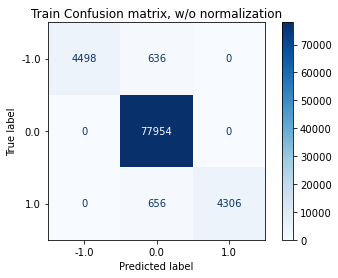

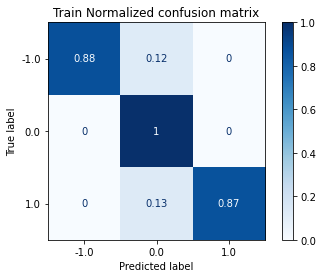

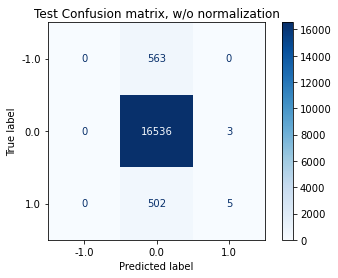

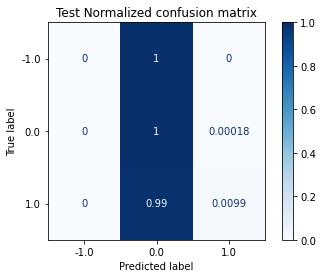

In [203]:
titles_options = [("Train Confusion matrix, w/o normalization", X_train, Y_train, None),
                  ("Train Normalized confusion matrix", X_train, Y_train, 'true'),
                  ("Test Confusion matrix, w/o normalization", X_test, Y_test, None),
                  ("Test Normalized confusion matrix", X_test, Y_test, 'true')]
for title, X, y, normalize in titles_options:
    disp = metrics.plot_confusion_matrix(model, X, y,
                                 display_labels=model.classes_,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

plt.show()

Average precision score, micro-averaged over all classes: 0.97


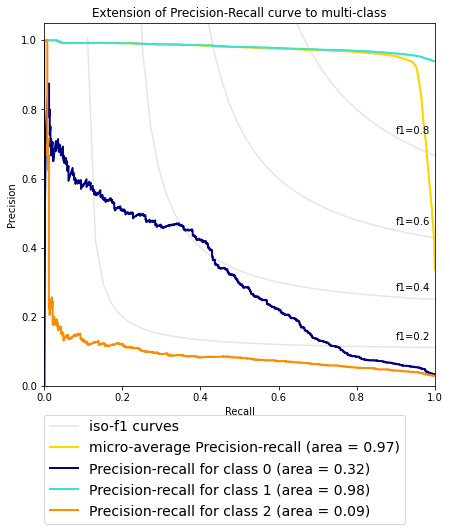

In [204]:
#entnommen aus
#https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html

y_score = model.predict_proba(X_test)

n_classes = 3

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize
Y_test_bin = label_binarize(Y_test, classes=[-1, 0, 1])

# For each class
precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(Y_test_bin[:, i],
                                                        y_score[:, i])
    average_precision[i] = average_precision_score(Y_test_bin[:, i], y_score[:, i])

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(Y_test_bin.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(Y_test_bin, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue', 'teal'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='gray', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(range(n_classes), colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(0, -.38), prop=dict(size=14))


plt.show()

Die shap-Werte der einzelnen Features unterscheiden sich z.T. sehr von Durchlauf zu Durchlauf und Training zu Test. Ein logischer Zusammenhang ist nicht zu erkennen. Auch das spricht vermutlich für ein stark overfittendes Modell.

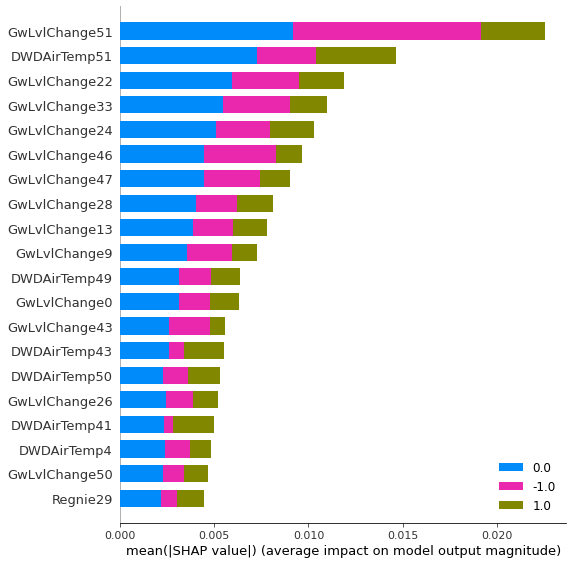

In [205]:
shap_values = shap.TreeExplainer(model).shap_values(X_train.iloc[:1000,:])
shap.summary_plot(shap_values, X_train, class_names=model.classes_, plot_type="bar")

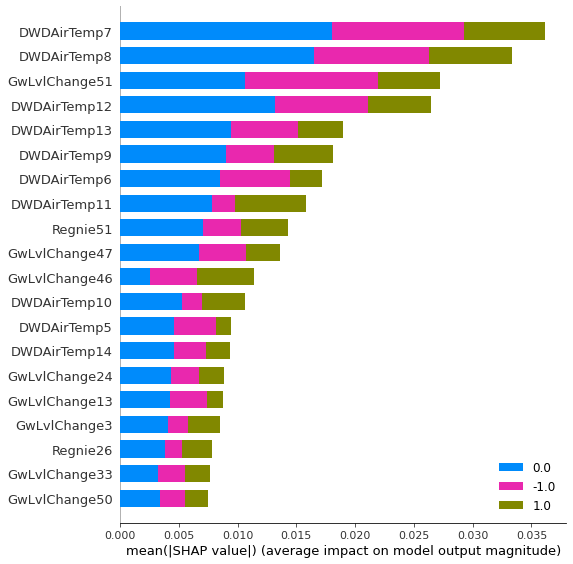

In [206]:
shap_values = shap.TreeExplainer(model).shap_values(X_test.iloc[:1000,:])
shap.summary_plot(shap_values, X_test, class_names=model.classes_, plot_type="bar")